## Plant Classfication (with neural network from scratch)
Make Money with Machine Learning week 7 homework  
using Kaggle dataset from [Weed Detection in Soybean Crops](https://www.kaggle.com/fpeccia/weed-detection-in-soybean-crops)

## Import required modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

## Dataset

In [29]:
path = Path('data')
classes = [plant.name for plant in path.iterdir()]
n_classes = len(classes)
print(f'Number of classes: {n_classes}')
print(f'Class labels: {classes}')

Number of classes: 4
Class labels: ['broadleaf', 'grass', 'soil', 'soybean']


In [30]:
n_images = []
print('Number of images in each class')
for i in range(n_classes):
    plant = classes[i]
    n_images.append(len(list((path/plant).iterdir())))
    print(f'{plant}: {n_images[-1]}')

Number of images in each class
broadleaf: 1191
grass: 3520
soil: 3249
soybean: 7376


## Functions related to data preparation

In [ ]:
def make_batch(img_paths, img_labels, batch_size):
    """
    Batch images for training
    Args:
        img_paths: np array of paths to training image files
        img_labels: np array of true class labels of the training images
        batch_size: number of images per batch
    Returns:
        generator of batches of image paths and labels
    """    
    shuffled_idx = np.random.permutation(img_paths.shape[0])
    img_paths = img_paths[shuffled_idx]
    img_labels = img_labels[shuffled_idx]
    n_batches = int(img_paths.shape[0]/batch_size) # last batch < batch_size is ignored
    for i in range(n_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        yield (img_paths[start:end], img_labels[start:end])

In [ ]:
def load_img(img_paths):
    """
    Load and preprocess images for training and prediction
    Args:
        img_paths: np array of paths to training image files
    Returns:
        X: 2d np array, each column is a flattened vector of pixels of an image 
    """
    n_images = img_paths.shape[0]
    
    # Create numpy array to hold image pixel values
    X = np.empty((n_images, img_height, img_width, channels), dtype=np.float64)

    for idx, img_path in enumerate(img_paths):
        # print(img_path)
        # print(cv2.imread(img_path).shape)
        X[idx] = cv2.resize(cv2.imread(img_path),(img_width, img_height))

    # Flatten image arrays so that each column represents an image
    X = X.reshape((n_images, -1))
    X = X.T
    # Scale the pixel values
    X = X / 255

    return X

## Functions related to the model

In [ ]:
def initialize_parameters(layer_units):
    """
    Initialize weights and biases of hidden layers and output layer of a neural network
    Args:
        layer_units: python list of number of units in each layer
                     For an L-layer neural network
                     layer_units[0] == number of input features
                     layer_units[L] == number of output units 
                         (1 output unit -> binary classification, 
                          n output units -> n-classs classification)
    Returns:
        W: python dict of weights matrix of layers 1 to L (initialized randomly)
        B: python dict of biases matrix of layers 1 to L (initialized to zeros)
    """
    # Seed for consistent random values
    np.random.seed(1)
    L = len(layer_units) - 1
    W = dict()
    B = dict()
    
    for layer in range(1, L+1):
        W[layer] = np.random.randn(layer_units[layer], layer_units[layer-1])
        # Modify M[layer] by multiplying it with a factor
        # Try different factors to see the different impact on cost optimization
        # factor1 is different value for layers (1):0.00902..., (2):0.22360..., (3):0.37796..., (4):0.44721...)
        # layer with less number of units will get a larger factor
        factor1 = 1 / np.sqrt(layer_units[layer-1]) 
        # factor2 is 0.01 for all layers
        factor2 = 0.01
        W[layer] = W[layer] * factor1 # toggle factor1 and factor2 to see the difference
        B[layer] = np.zeros((layer_units[layer], 1))
    return W, B

In [ ]:
def relu(Z):
    """
    Compute relu function of Z
    Args:
        Z: np array of any shape
    Returns:
        value of relu function of Z
    """
    return np.maximum(0, Z) # array of max values elementwise

def relu_derivative(Z):
    """
    Compute derivative of relu function of Z
    Args:
        Z: np array of any shape
    Returns:
        derivative of relu function of Z
    """
    return np.where(Z <= 0, 0, 1)

In [ ]:
def softmax(Z):
    """
    Compute softmax function of Z
    Args:
        Z: np array of any shap;
    Returns:
        value of softmax function of A
    """
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True)

In [ ]:
def forward_prop(X, W, B):
    """
    Compute forward propagation of neural network
    Args:
        X: 2d np array with each column representing a training example
        W: python dict of weights matrix of layers 1 to L 
        B: python dict of biases matrix of layers 1 to L
    
    Returns:
        Z: python dict of weighted sums of inputs to each layer
        A: python dict of activation output from each layer
    """
    L = len(W) # Number of layers
    A = dict() 
    Z = dict()
    
    # layer 1 to L-1, ReLU activation
    A[0] = X
    for layer in range(1, L):
        Z[layer] = np.dot(W[layer], A[layer-1]) + B[layer]
        A[layer] = relu(Z[layer])
        
    # layer L (output layer), 
    Z[L] = np.dot(W[L], A[L-1]) + B[L]
    # softmax activation for multi-class classification
    A[L] = softmax(Z[L])
    
    return A, Z

In [ ]:
def one_hot_encode(y, n_classes):
    """
    Convert class labels into one-hot-encoded vectors
    Args:
        y: true labels
        n_classes: number of classes
    Returns:
        Y: 2d np array, each column represents a class label as a one-hot vector
    """
    Y = np.zeros((n_classes, y.shape[0]))
    Y[y, np.arange(y.shape[0])] = 1
    return Y

In [ ]:
def compute_cost(AL, y):
    """
    Args:
        AL: activation of output layer i.e. A[L]
        y: true labels
    Returns:
        cost: cross-entropy loss
    """
    Y = one_hot_encode(y, n_classes)
    cost = -np.mean(Y * np.log(AL))
    return cost


In [ ]:
def backward_prop(A, Z, y, W):
    """
    Compute backward propagation of neural network
    Args:
        A: python dict of activation output from each layer
        Z: python dict of weighted sums of inputs to each layer
        y: True labels
        W: python dict of weights matrix of layers 1 to L 
        B: python dict of biases matrix of layers 1 to L
    Returns:
        dW: python dict of gradinet of cost with respect to weight matrix of layers 1 to L
        dB: python dict of gradinet of cost with respect to bias matrix of layers 1 to L
    """
    L = len(W) # Number of layers
    Y = one_hot_encode(y, n_classes)
    dA = dict()
    dW = dict()
    dB = dict()
    
    dZ = A[L] - Y
    
    for layer in reversed(range(1, L+1)):
        m = A[layer-1].shape[1]
        dW[layer] = np.dot(dZ, A[layer-1].T)/m
        dB[layer] = dZ.sum(axis=1, keepdims=True)/m
        if layer > 1:
            dA[layer-1] = np.dot(W[layer].T, dZ)
            dZ = dA[layer-1] * relu_derivative(Z[layer-1]) 
    return dW, dB

In [ ]:
def update_parameters(W, B, dW, dB, learning_rate):
    """
    Update the weights and biases
    Args:
        W: python dict of weights matrix of layers 1 to L
        B: python dict of biases matrix of layers 1 to L
        dW: python dict of gradinet of cost with respect to weight matrix of layers 1 to L
        dB: python dict of gradinet of cost with respect to bias matrix of layers 1 to L
        learning_rate: learning rate of gradient descent
    Returns:
        W: python dict of weights matrix of layers 1 to L
        B: python dict of biases matrix of layers 1 to L
    """
    L = len(W) # Number of layers
    for layer in range(1, L+1):
        W[layer] = W[layer] - learning_rate * dW[layer]
        B[layer] = B[layer] - learning_rate * dB[layer]
    return W, B

In [ ]:
def train(img_paths, img_labels, layer_units, learning_rate=0.0075, n_iter=3000, batch_size=64, print_cost=False):
    """
    Train the model
    Args:
        img_paths: np array of paths to training image files
        img_labels: np array of true class labels of the training images
        layer_units: python list of number of units in each layer
                     For an L-layer neural network
                     layer_units[0] == number of input features
                     layer_units[L] == number of output units 
                         (1 output unit -> binary classification, 
                          n output units -> n-classs classification) 
        learning_rate: learning rate of gradient descent
        n_iter: number of forward propagation / backward propagation / update parameter cycles
        batch_size: number of training images processed per iteration
        print_cost: boolean, print the cost periodically during training
    Returns:
        W: python dict of weights matrix of layers 1 to L
        B: python dict of biases matrix of layers 1 to L
    """
    print('Training the model...')
    np.random.seed(1)
    costs = []
    L = len(layer_units) - 1
    batch = make_batch(img_paths, img_labels, batch_size)
    W, B = initialize_parameters(layer_units)
    for i in range(n_iter):
        try:
            batch_paths, batch_labels = next(batch)
        except:
            batch = make_batch(img_paths, img_labels, batch_size)
            batch_paths, batch_labels = next(batch)

        X = load_img(batch_paths)
        y = batch_labels 
        A, Z = forward_prop(X, W, B)
        cost = compute_cost(A[L], y)
        dW, dB = backward_prop(A, Z, y, W)
        W, B = update_parameters(W, B, dW, dB, learning_rate)
    # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return W, B

In [ ]:
def predict(img_paths, W, B):
    """
    Predict the classes of images
    Args:
        img_paths: np array of paths to image files
        W: python dict of weights matrix of layers 1 to L
        B: python dict of biases matrix of layers 1 to L
    Returns:
        predictions: np array of predicted class labels of the images
        probabilities: np array of the predicted probabilities of the classes
    """
    L = len(W) # Number of layers
    X = load_img(img_paths)
    A, Z = forward_prop(X, W, B)
    predictions = np.argmax(A[L], axis=0)
    probabilities = np.max(A[L], axis=0)
    return predictions, probabilities

def compute_accuracy(img_paths, img_labels, W, B):
    """
    Compute the accuracy of prediction
    Args:
        img_paths: np array of paths to image files
        img_labels: np array of true class labels of the images
        W: python dict of weights matrix of layers 1 to L
        B: python dict of biases matrix of layers 1 to L
    Returns:
        accuracy: accuracy of the predictions
    """   
    y = img_labels
    predictions, _ = predict(img_paths, W, B)
    y = y.reshape(predictions.shape) # Make sure they have the same shape
    accuracy = np.mean(predictions==y)
    return accuracy

In [ ]:
def predict_plot(img_path, img_label, W, B):
    """
    Show an image with its predicted class, probability and true class
    Args:
        img_path: path to one single image file to predict
        img_label: true label of the image
        W: python dict of weights matrix of layers 1 to L
        B: python dict of biases matrix of layers 1 to L
    Returns:
        None (only shows an image with predictions)
    """
    predictions, probabilities = predict(np.array([img_path]), W, B)
    img = cv2.resize(cv2.imread(img_path), (img_width, img_height))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

    if predictions[0] == img_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{}: {:0.2f} / ({})".format(classes[predictions[0]],
                                probabilities[0],
                                classes[img_label]),
                                color=color)

## Prepare the data

### Images will be resized as follows 

In [ ]:
img_width = 200
img_height = 200
channels = 3

### Split data into training, validation and test sets

In [ ]:
np.random.seed(1)
# Randomly pick same number of image paths from each class
# and store them in a list
pick_size = min(n_images)
img_paths = []
img_labels = []
label = 0 # integer code for plant classes
for plant, images in zip(classes, n_images):
    shuffled_idx = np.random.permutation(range(1, images+1))
    # img_paths += list(map(lambda x: convert_to_path(x, plant), shuffled_idx[:pick_size]))
    img_paths += list(map(lambda img_no: f'/content/data/dataset/{plant}/{str(img_no)}.tif', shuffled_idx[:pick_size]))
    img_labels += [label] * pick_size
    label += 1

# Convert lists into numpy arrays
img_paths = np.array(img_paths)
img_labels = np.array(img_labels)

# Shuffle the img_paths (together with their labels)
shuffled_idx = np.random.permutation(len(img_paths))
img_paths = img_paths[shuffled_idx]
img_labels = img_labels[shuffled_idx]

# Split into train, validation and test sets
train_size = 0.7
valid_size = 0.2
train_split = int(len(img_paths)*0.7)
valid_split = train_split + int(len(img_paths)*0.1)

train_paths = img_paths[:train_split]
train_labels = img_labels[:train_split]

valid_paths = img_paths[train_split:valid_split]
valid_labels = img_labels[train_split:valid_split]

test_paths = img_paths[valid_split:]
test_labels = img_labels[valid_split:]

## Train the model
The model is a neural network with 2 hidden layers of 64 units each.



Training the model...
Cost after iteration 0: 0.337398
Cost after iteration 100: 0.217682
Cost after iteration 200: 0.168485
Cost after iteration 300: 0.149808
Cost after iteration 400: 0.115340
Cost after iteration 500: 0.121924
Cost after iteration 600: 0.146432
Cost after iteration 700: 0.144574
Cost after iteration 800: 0.113234
Cost after iteration 900: 0.100370
Cost after iteration 1000: 0.083132
Cost after iteration 1100: 0.136811
Cost after iteration 1200: 0.079258
Cost after iteration 1300: 0.115645
Cost after iteration 1400: 0.108043
Cost after iteration 1500: 0.148711
Cost after iteration 1600: 0.072218
Cost after iteration 1700: 0.054123
Cost after iteration 1800: 0.052294


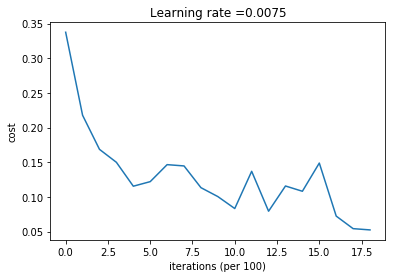

In [72]:
layer_units = [img_width * img_height * channels, 64, 64, n_classes]
W, B = train(train_paths, train_labels, layer_units, n_iter=1801, print_cost=True)

## Evaluate the model

In [75]:
train_acc = compute_accuracy(train_paths, train_labels, W, B)
valid_acc = compute_accuracy(valid_paths, valid_labels, W, B)
test_acc = compute_accuracy(test_paths, test_labels, W, B)
print(f'Training accuracy: {train_acc}')
print(f'Validation accuracy: {valid_acc}')
print(f'Test accuracy: {test_acc}')

Training accuracy: 0.891121775644871
Validation accuracy: 0.7836134453781513
Test accuracy: 0.7861635220125787


## Prediction Examples

### from validation set

Note:
predicted class: probability / (true class)
correct predictions in blue, wrong in red


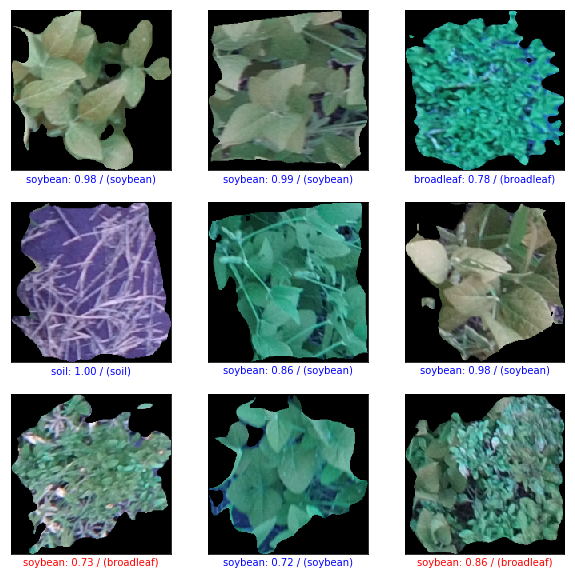

In [79]:
print('Note:')
print('predicted class: probability / (true class)')
print('correct predictions in blue, wrong in red')
plt.figure(figsize=(10, 10))
shuffled_idx = np.random.permutation(valid_paths.shape[0])
for i in range(9):
    idx = shuffled_idx[i]
    img_path = valid_paths[idx]
    img_label = valid_labels[idx]
    plt.subplot(3, 3, i+1)
    predict_plot(img_path, img_label, W, B)

### from test set

Note:
predicted class: probability / (true class)
correct predictions in blue, wrong in red


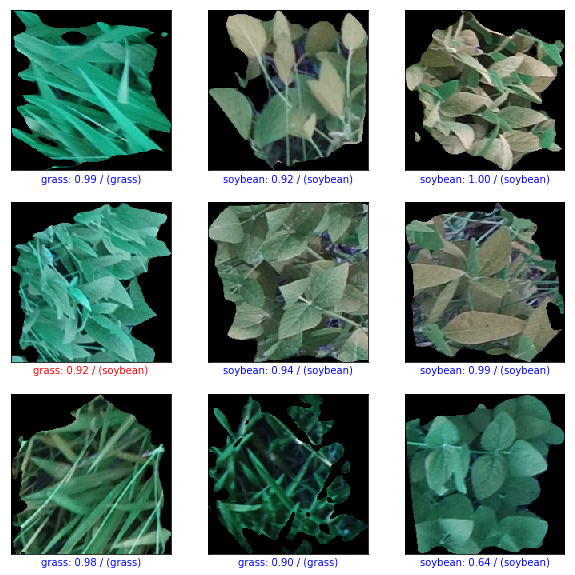

In [81]:
print('Note:')
print('predicted class: probability / (true class)')
print('correct predictions in blue, wrong in red')
plt.figure(figsize=(10, 10))
shuffled_idx = np.random.permutation(test_paths.shape[0])
for i in range(9):
    idx = shuffled_idx[i]
    img_path = test_paths[idx]
    img_label = test_labels[idx]
    plt.subplot(3, 3, i+1)
    predict_plot(img_path, img_label, W, B)